In [2]:
from langgraph.graph import StateGraph, START, END 
import os 
from langchain_google_genai import ChatGoogleGenerativeAI 
from typing import TypedDict, Annotated, Literal
from pydantic import BaseModel,Field  
from dotenv import load_dotenv

An error occurred: module 'importlib.metadata' has no attribute 'packages_distributions'


c:\Users\SAMARTH\Desktop\AgenticAI\.venv\lib\site-packages\google\api_core\_python_version_support.py:252: FutureWarning: You are using a Python version (3.9.7) past its end of life. Google will update google.api_core with critical bug fixes on a best-effort basis, but not with any other fixes or features. Please upgrade to the latest Python version, or at least Python 3.10, and then update google.api_core.
  warnings.warn(message, FutureWarning)


In [3]:
load_dotenv()

True

In [4]:
os.environ['GOOGLE_API_KEY'] = os.getenv('gemini_api_key')

In [6]:
model = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [5]:
class SentimentSchema(BaseModel):
    sentiment: Literal['positive','negative'] = Field(description="Sentiment of the Customer Review")
 

In [7]:
structured_model = model.with_structured_output(SentimentSchema)

In [10]:
prompt = f'You are help Assistant helps in finding the sentiment of the customer review: The software is too bad' 

In [12]:
structured_model.invoke(prompt).sentiment

'negative'

In [13]:
class ReviewState(TypedDict):
    review: str
    sentiment: Literal["positive", "negative"] 
    diagnosis : dict
    response : str

In [48]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX","Performance","Bug", "support","other"] = Field(description="The category of the issue mentioned in the review")
    tone: Literal["angry", "frustated", "disappointed", "calm"] = Field(description= "The emotional tome by the user") 
    urgency : Literal["low","mediun", "high"] = Field(description="How urgent or critical the issue is ")

In [49]:
structured_model1 = model.with_structured_output(SentimentSchema) 
structured_model2 = model.with_structured_output(DiagnosisSchema)

In [55]:
def find_sentiment(state:ReviewState):
    prompt = f'For the following review find out the sentiment \n {state["review"]}' 
    sentiment = structured_model1.invoke(prompt).sentiment 

    return {'sentiment':sentiment} 

def check_sentiment(state:ReviewState) -> Literal["postive_response","run_diagnosis"] : 
    if state["sentiment"] == "positive" : 
        return "postive_response"
    else:
        return "run_diagnosis" 
    
def postive_response(state:ReviewState):
    prompt = f"""Write a warm thank you message in the response to this review: \n\n "{state["review"]}
Also as user to leave a valuable feedback on ourwebsite """
    response = model.invoke(prompt).content 

    return {
        "response" : response
    } 

def run_diagnosis(state:ReviewState) : 
    prompt = f""" Diagnosos this negative review: \n \n {state['review']}
                "return issu_type, tone and urgency """
    diagnosis = structured_model2.invoke(prompt)
    print(diagnosis)

    return {
        "diagnosis" : diagnosis.model_dump()
    }

def negative_response(state:ReviewState):
    diagnosis = state["diagnosis"]
    prompt = f"""You are support assistant. 
    The User had a {diagnosis['issue_type']} issue, sounded {diagnosis["tone"]} and marked the urgency of {diagnosis["urgency"]} 
    Write an empathetic, helpful resolution message""" 
    response = model.invoke(prompt).content

    return {
        "response" : response
    }

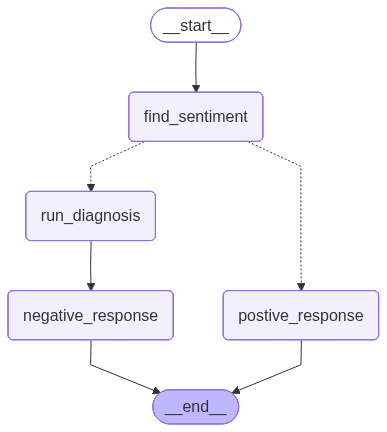

In [56]:
graph = StateGraph(ReviewState)


graph.add_node('find_sentiment',find_sentiment) 
graph.add_node("postive_response", postive_response)
graph.add_node("negative_response", negative_response)
graph.add_node("run_diagnosis",run_diagnosis)
# graph.add_node('check_sentiment', check_sentiment)

graph.add_edge(START,'find_sentiment') 
graph.add_conditional_edges('find_sentiment',check_sentiment)
graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge("postive_response", END)
graph.add_edge('negative_response', END) 

graph.compile()



In [57]:
workflow = graph.compile() 


In [60]:
intial_state = {
    "review" : "Thank you for the product I like from start to end "
} 



In [61]:
workflow.invoke(intial_state)

{'review': 'Thank you for the product I like from start to end ',
 'sentiment': 'positive',
 'response': 'Here are a few options, choose the one that best fits your brand\'s voice!\n\n**Option 1 (Concise & Enthusiastic):**\n\n> Thank you so much for your wonderful review! We\'re absolutely delighted to hear that you liked the product "from start to end" – that\'s truly fantastic feedback for us! We really appreciate you taking the time to share your valuable input on our website. It means a lot!\n\n**Option 2 (Slightly more detailed):**\n\n> We\'re so glad to read your fantastic review! Thank you for letting us know you enjoyed the product "from start to end." Hearing that kind of feedback truly makes our day! We also really appreciate you taking the time to leave your valuable thoughts here on our website.\n\n**Option 3 (Warm & Heartfelt):**\n\n> What a lovely review, thank you so much! It makes us incredibly happy to hear that you liked the product "from start to end." We genuinely a